In [1]:
# 自动计算cell的计算时间
%load_ext autotime

#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[2] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 4.01 s (started: 2021-07-25 12:04:35 +08:00)


In [2]:
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 10.1 ms (started: 2021-07-25 12:04:40 +08:00)


# 神经网络入门：分类和回归

> 本章包含
* 真实世界机器学习工作流程的第一个示例
* 处理矢量数据的分类问题
* 处理向量数据上的连续回归问题

本章旨在帮助您开始使用神经网络解决实际问题。 您将巩固从第 2 章和第 3 章中获得的知识，并将所学应用于三个新任务，涵盖神经网络的三个最常见用例——二元分类、多类分类和标量回归：
* 将电影评论分类为正面或负面（二元分类）
* 按主题对新闻线进行分类（多类分类）
* 给定房地产数据估计房屋价格（标量回归）

这些示例将是您第一次接触端到端机器学习工作流：您将了解数据预处理、基本模型架构原则和模型评估。

到本章结束时，您将能够使用神经网络处理向量数据上的简单分类和回归任务。 然后，您将准备好在第 5 章中开始构建对机器学习的更有原则的、理论驱动的理解。

> 分类和回归词汇表

分类和回归涉及许多专业术语。 您已经在前面的示例中遇到过其中的一些，并且您将在以后的章节中看到更多。 它们具有精确的、特定于机器学习的定义，您应该熟悉它们：
* 样本或 - 进入模型的一个数据点。 输入
* 预测或 - 从您的模型中得出什么结果。 输出
* 目标——真相。 根据外部数据源，您的模型理想情况下应该预测的内容。
* 预测误差或 — 损失值模型预测与目标之间距离的度量。
* Classes - 在分类中可供选择的一组可能的标签
* 问题。 例如，在对猫狗图片进行分类时，“狗”和“猫”就是两个类。
* 标签 - 分类中类注释的特定实例
* 问题。 例如，如果图片 #1234 被注释为包含
* 类“狗”，然后“狗”是图片#1234的标签。
* Ground-truth 或注释——数据集的所有目标，通常由人类收集。
* 二元分类——一个分类任务，其中每个输入样本
* 应该归为两个唯一的类别。
* 多类分类——一种分类任务，其中每个输入样本应分为两个以上的类别：例如，对手写数字进行分类。
* 多标签分类——一种分类任务，其中每个输入样本都可以分配多个标签。例如，给定的图像可能同时包含一只猫和一只狗，并且应该同时使用“猫”标签和“狗”标签进行注释。每个图像的标签数量通常是可变的。
* 标量回归——目标是连续标量值的任务。
* 预测房价就是一个很好的例子：不同的目标价格形成一个连续的空间。
* 向量回归 — 目标是一组连续值的任务：例如，连续向量。如果您对多个值（例如图像中边界框的坐标）进行回归，那么您就是在进行向量回归。
* 小批量或 - 由模型同时处理的一小组样本（通常在 8 到 128 之间）。样本数通常是 2 的幂，以方便 GPU 上的内存分配。
训练时，小批量用于计算应用于模型权重的单个梯度下降更新。

## 电影评论分类：二元分类示例

两类分类或二元分类是最常见的机器学习问题之一。 在此示例中，您将学习根据评论的文本内容将电影评论分为正面或负面。

### The IMDB dataset

您将使用 IMDB 数据集：一组来自互联网电影数据库的 50,000 条高度分化的评论。 它们分为 25,000 条用于训练的评论和 25,000 条用于测试的评论，每组包含 50% 的负面评论和 50% 的正面评论。

就像 MNIST 数据集一样，IMDB 数据集与 Keras 打包在一起。 它已经过预处理：评论（单词序列）已经变成了整数序列，其中每个整数代表字典中的特定单词。 这使我们能够专注于模型构建、训练和评估。 在第 11 章中，您将学习如何从头开始处理原始文本输入。

下面的代码将加载数据集（当你第一次运行它时，大约 80 MB 的数据将被下载到你的机器上）。

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 22s 1us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


time: 29.7 s (started: 2021-07-22 13:53:47 +08:00)


/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


参数 num_words=10000 意味着您将只保留训练数据中出现频率最高的前 10,000 个单词。 生僻字将被丢弃。 这允许您使用可管理大小的矢量数据。 如果我们不设置这个限制，我们将在训练数据中使用 88,585 个唯一词，这会不必要地大。 许多这些词只出现在一个样本中，因此不能有意义地用于分类。

变量 train_data test_data 和评论列表； 每个评论都是一个单词索引列表（编码一个单词序列）。 train_labels test_labels 是 0 和 1 的列表，其中 0 代表 1 代表：

In [4]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

time: 13.3 ms (started: 2021-07-22 15:16:12 +08:00)


In [5]:
train_labels[0]

1

time: 2.74 ms (started: 2021-07-22 15:16:32 +08:00)


因为您将自己限制在最常用的前 10,000 个单词中，所以没有单词索引会超过 10,000：

In [6]:
max([max(sequence) for sequence in train_data])

9999

time: 163 ms (started: 2021-07-22 15:17:33 +08:00)


对于踢球，您可以通过以下方法将这些评论之一快速解码回英文单词：

In [8]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 2s 1us/step
time: 1.91 s (started: 2021-07-22 15:18:41 +08:00)


In [9]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

time: 56.3 ms (started: 2021-07-22 15:18:57 +08:00)


In [11]:
# 解码评论。 请注意，索引偏移了 3，因为 0、1 和 2 是“填充”、“序列开始”和“未知”的保留索引。
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

time: 828 µs (started: 2021-07-22 15:21:47 +08:00)


### 准备数据

你不能直接将整数列表输入神经网络。 它们的长度各不相同，但神经网络希望处理连续的批次数据。 你必须把你的列表变成张量。 有两种方法可以做到这一点：

你不能直接将整数列表输入神经网络。 它们的长度各不相同，但神经网络希望处理连续的批次数据。 你必须把你的列表变成张量。 有两种方法可以做到这一点：
* 填充您的列表，使它们都具有相同的长度，然后将它们转换为形状的整数张量（样本，max_length），并以能够处理此类整数张量的层（该层，我们将在其中介绍）开始您的模型 稍后在嵌入本书中详细介绍）。
* 多热编码您的列表以将它们转换为 0 和 1 的向量。 这意味着，例如，将序列 [8, 5] 转换为 10,000 维向量，除了索引 8 和 5 为 1 外，该向量全为 0。 然后，您可以使用能够处理浮点矢量数据的 Dense 层作为模型中的第一层。

让我们使用后一种解决方案来对数据进行矢量化，为了最大程度地清晰，您将手动执行此操作。

In [16]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    
    #创建一个全零矩阵的形状（len（序列），维度）
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            # 将结果 [i] 的特定索引设置为 1s
            results[i, j] = 1.
    return results

# 矢量化训练数据
x_train = vectorize_sequences(train_data)
# 矢量化测试数据
x_test = vectorize_sequences(test_data)

time: 415 ms (started: 2021-07-23 14:25:12 +08:00)


以下是样本现在的样子：

In [14]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

time: 2.54 ms (started: 2021-07-22 15:30:17 +08:00)


您还应该矢量化您的标签，这很简单：

In [15]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

time: 1.42 ms (started: 2021-07-22 15:31:05 +08:00)


现在数据已准备好输入神经网络。

### 构建模型

输入数据是向量，标签是标量（1 和 0）：这是您遇到的最简单的问题设置之一。 在此类问题上表现良好的一种模型是具有激活的密集连接 ( ) 层的普通堆栈。

输入数据是向量，标签是标量（1 和 0）：这是您遇到的最简单的问题设置之一。 在此类问题上表现良好的一种模型是具有 relu 激活的密集连接（dense）层的简单堆栈。

关于这样的密集层堆栈，需要做出两个关键的架构决策：
* 使用多少层
* 每层选择多少个单位

在第 5 章中，您将学习指导您做出这些选择的正式原则。 目前，您必须相信我的以下架构选择：
* 两个中间层，每层 16 个单元
* 第三层将输出关于当前评论情绪的标量预测

图 4.1 显示了模型的外观。 这是 Keras 实现，类似于您之前看到的 MNIST 示例。

![](https://tva1.sinaimg.cn/large/008i3skNly1gsps2310jnj30hi0pkq3v.jpg)

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

time: 1.62 s (started: 2021-07-22 15:52:31 +08:00)


传递给每一层的第一个参数是层中的数量：层表示空间的密集单位维数。 您还记得第 2 章和第 3 章中的每个具有激活的层都实现了以下张量密集 relu 操作链：

In [ ]:
output = relu(dot(input, W) + b)

有 16 个单位意味着权重矩阵将具有形状 W (input_dimension, 16)：点积与将输入数据投影到 16 维表示空间（然后 W 将添加偏置向量并应用操作）。 您可以直观地将表示空间的 b relu 维数理解为“在学习内部表示时，您允许模型拥有多少自由度”。 拥有更多单元（更高维的表示空间）可以让您的模型学习更复杂的表示，但它会使模型的计算成本更高，并可能导致学习不需要的模式（将提高训练数据性能但不会提高测试数据的性能） 测试数据）。

中间层用作它们的激活函数，最后一层使用 sigmoid relu 激活以输出概率（0 到 1 之间的分数，表示样本有多少可能有目标“1”：评论的可能性有多大 是积极的）。 A（整流线性 relu 单元）是一个函数，旨在将负值归零（见图 4.2），而 sigmoid 将任意值“压缩”到区间中（见图 4.3），输出 [0, 1] 可以解释的东西 作为概率。

![](https://tva1.sinaimg.cn/large/008i3skNly1gsps6hbncmj30n40req46.jpg)

> 什么是激活函数，为什么需要它们？

如果没有像 relu（也称为 relu 非线性）这样的激活函数，密集层将包含两个线性运算——点积和加法：

In [ ]:
output = dot(input, W) + b

因此该层只能学习输入数据的线性变换（仿射变换）：该层的假设空间将是输入数据到 16 维空间的所有可能线性变换的集合。 这样的假设空间太受限制，不会从多层表示中受益，因为深度堆叠的线性层仍然会实现线性操作：添加更多层不会扩展假设空间（如您在第 2 章中看到的） .

为了获得更丰富的假设空间，
从深度表示中受益，您需要非线性或激活函数。 relu是深度学习中最流行的激活函数，但是relu还有很多其他的候选函数，它们都有类似奇怪的名字：prelu、elu等等。

最后，您需要选择一个损失函数和一个优化器。 因为您面临二元分类问题，并且模型的输出是概率（您以具有 sigmoid 激活的单单元层结束模型），所以最好使用 binary_crossentropy 损失。 这不是唯一可行的选择：例如，您可以使用 mean_squared_error。 但是当您处理输出概率的模型时，交叉熵通常是最佳选择。 交叉熵是来自信息论领域的一个量，用于测量概率分布之间的距离，或者在这种情况下，真实分布与预测之间的距离。

至于优化器的选择，我们将使用 rmsprop，对于几乎任何问题，这通常是一个很好的默认 rmsprop 选择。

这是使用 rmsprop 优化器和 binary_crossentropy 损失函数配置模型的步骤。 请注意，您还将在训练期间监控准确性。

In [19]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

time: 25.1 ms (started: 2021-07-22 16:01:22 +08:00)


### 验证您的方法

正如您在第 3 章中了解到的，永远不应根据其训练数据评估深度学习模型——标准做法是在训练期间使用“验证集”来监控模型的准确性。 在这里，您将通过从原始训练数据中分离出 10,000 个样本来创建验证集。

In [21]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

time: 855 µs (started: 2021-07-22 16:50:45 +08:00)


您现在将以 512 个样本的小批量训练模型 20 个时期（对训练数据中的所有样本进行 20 次迭代）。 同时，您将监控您分开的 10,000 个样本的损失和准确度。 您可以通过将验证数据作为validation_data 参数传递来实现。

In [22]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 5s 53ms/step - loss: 0.5269 - accuracy: 0.7865 - val_loss: 0.4028 - val_accuracy: 0.8706
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 0.3201 - accuracy: 0.9016 - val_loss: 0.3389 - val_accuracy: 0.8661
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2304 - accuracy: 0.9266 - val_loss: 0.2801 - val_accuracy: 0.8920
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1812 - accuracy: 0.9407 - val_loss: 0.2883 - val_accuracy: 0.8838
Epoch 5/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1488 - accuracy: 0.9508 - val_loss: 0.2799 - val_accuracy: 0.8872
Epoch 6/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1238 - accuracy: 0.9616 - val_loss: 0.2994 - val_accuracy: 0.8824
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1016 - accuracy: 0.9701 - val_loss: 0.3057 - val_accuracy: 0.8825
Epoch 8/20
30

在 CPU 上，这将花费每个 epoch 不到 2 秒的时间——训练在 20 秒内结束。 在每个 epoch 结束时，模型会在 10,000 个验证数据样本上计算其损失和准确度，因此会有轻微的停顿。

请注意，调用 model.fit() 返回一个 History 对象，正如您在第 3 章中看到的那样。该对象有一个成员 ，它是一个字典，其中包含有关训练期间发生的所有历史数据的数据。 让我们来看看：

In [23]:
history_dict = history.history

time: 453 µs (started: 2021-07-22 16:54:56 +08:00)


In [24]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

time: 2.38 ms (started: 2021-07-22 16:55:08 +08:00)


In [27]:
import pandas as pd

time: 461 µs (started: 2021-07-22 16:55:41 +08:00)


In [34]:
history.history

{'loss': [0.526863694190979,
  0.320054292678833,
  0.23038016259670258,
  0.18120521306991577,
  0.14881940186023712,
  0.12377016246318817,
  0.10163230448961258,
  0.08668980002403259,
  0.06957581639289856,
  0.05931144952774048,
  0.04841609671711922,
  0.040512919425964355,
  0.03139404579997063,
  0.028269965201616287,
  0.020131245255470276,
  0.01613525114953518,
  0.015231958590447903,
  0.010360080748796463,
  0.008133160881698132,
  0.0048561799339950085],
 'accuracy': [0.7865333557128906,
  0.9016000032424927,
  0.9265999794006348,
  0.9407333135604858,
  0.9508000016212463,
  0.9616000056266785,
  0.9701333045959473,
  0.9737333059310913,
  0.9804666638374329,
  0.9844666719436646,
  0.9872000217437744,
  0.9901999831199646,
  0.9932000041007996,
  0.9936000108718872,
  0.9968000054359436,
  0.9974666833877563,
  0.9967333078384399,
  0.998533308506012,
  0.9988666772842407,
  0.9998666644096375],
 'val_loss': [0.4028334617614746,
  0.338904470205307,
  0.2801274955272674

time: 2.48 ms (started: 2021-07-22 16:56:40 +08:00)


In [35]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.526864,0.786533,0.402833,0.8706
1,0.320054,0.901600,0.338904,0.8661
2,0.230380,0.926600,0.280127,0.8920
3,0.181205,0.940733,0.288270,0.8838
4,0.148819,0.950800,0.279924,0.8872
5,0.123770,0.961600,0.299435,0.8824
6,0.101632,0.970133,0.305663,0.8825
7,0.086690,0.973733,0.326077,0.8809
8,0.069576,0.980467,0.357641,0.8775
9,0.059311,0.984467,0.374644,0.8778


time: 13.9 ms (started: 2021-07-22 16:56:50 +08:00)


该字典包含四个条目：每个在训练和验证期间被监控的指标一个。 在以下两个清单中，让我们使用 Matplotlib 并排绘制训练和验证损失（见图 4.4），以及训练和验证准确度（见图 4.5）。 请注意，由于模型的随机初始化不同，您自己的结果可能会略有不同。

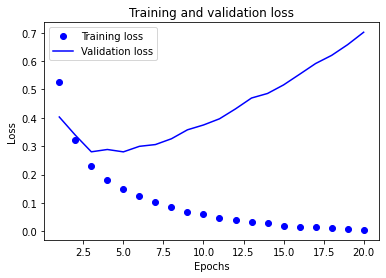

time: 766 ms (started: 2021-07-22 17:00:12 +08:00)


In [36]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

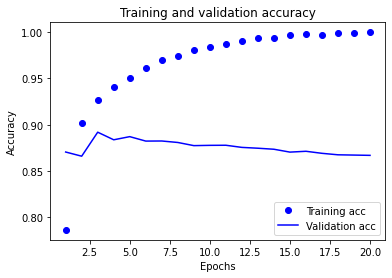

time: 733 ms (started: 2021-07-22 17:05:35 +08:00)


In [37]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

如您所见，训练损失随着每个 epoch 减少，而训练准确度随着每个 epoch 增加。 这就是您在运行梯度下降优化时所期望的——每次迭代时您试图最小化的数量应该更少。 但是塔
验证损失和准确性并非如此：它们似乎在第四个时期达到顶峰。 这是我们之前警告过的一个例子：在训练数据上表现更好的模型不一定是在以前从未见过的数据上表现更好的模型。 准确地说，您所看到的是：在第四个时期之后，您对训练过度拟合数据进行了过度优化，并且最终学习了特定于训练数据的表示，并且不会泛化到外部数据 训练集。

在这种情况下，为了防止过度拟合，您可以在四个 epoch 后停止训练。 一般来说，您可以使用一系列技术来减轻过拟合，我们将在第 5 章中介绍。

让我们从头开始训练一个新模型四个时期，然后在测试数据上对其进行评估。

In [38]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 2s 19ms/step - loss: 0.4582 - accuracy: 0.8286
Epoch 2/4
49/49 [==============================] - 1s 19ms/step - loss: 0.2603 - accuracy: 0.9104
Epoch 3/4
49/49 [==============================] - 1s 15ms/step - loss: 0.2027 - accuracy: 0.9285
Epoch 4/4
49/49 [==============================] - 1s 15ms/step - loss: 0.1701 - accuracy: 0.9403


time: 5.59 s (started: 2021-07-22 17:08:49 +08:00)


In [39]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 6s 7ms/step - loss: 0.2982 - accuracy: 0.8807
time: 7.26 s (started: 2021-07-22 17:08:57 +08:00)


最终结果如下：

In [40]:
results

[0.29824867844581604, 0.8806800246238708]

time: 2.86 ms (started: 2021-07-22 17:09:43 +08:00)


第一个数字 0.29 是测试损失，第二个数字 0.88 是测试精度。

这种相当幼稚的方法达到了 88% 的准确率。 使用最先进的方法，您应该能够接近 95%。

### 使用经过训练的模型对新数据进行预测

训练模型后，您将希望在实际环境中使用它。 您可以使用该方法生成正面评价的可能性，正如您在第 3 章预测中学到的：

In [42]:
model.predict(x_test)

array([[0.2246211 ],
       [0.9999509 ],
       [0.9513612 ],
       ...,
       [0.17931864],
       [0.09724324],
       [0.7526973 ]], dtype=float32)

time: 4.12 s (started: 2021-07-22 17:12:19 +08:00)


如您所见，该模型对某些样本（0.99 或更多，或 0.01 或更少）有信心，但对其他样本（0.6、0.4）的信心较低。

### 进一步的实验

以下实验将帮助您相信您所做的架构选择都是相当合理的，尽管仍有改进的空间：
* 您在最终分类层之前使用了两个表示层。 尝试使用一到三个表示层，看看这样做会如何影响验证和测试准确性。
* 尝试使用具有更多单位或更少单位的图层：32 个单位、64 个单位等。
* 尝试使用mse损失函数而不是binary_crossentropy。
* 尝试使用tanh激活（一种在神经网络早期流行的激活）而不是 relu。

### 包起来

以下是你应该从这个例子中学到的东西：
* 您通常需要对原始数据进行大量预处理，以便能够将其作为张量输入到神经网络中。单词序列可以编码为二进制向量，但也有其他编码选项。
* 带有激活的堆叠层可以解决广泛的问题（包括情感分类），您可能会经常使用它们。
* 在二元分类问题（两个输出类）中，您的模型应该以一个带有一个单元和一个激活的 Dense 层结束：模型的输出应该是 sigmoid 一个介于 0 和 1 之间的标量，编码概率。
* 在二元分类问题上有这样一个标量 sigmoid 输出，你应该使用的损失函数是 binary_crossentropy。
* rmsprop 优化器通常是一个足够好的选择，无论您遇到什么问题。这是您不必担心的一件事。
* 随着他们在训练数据上变得更好，神经网络最终开始过度拟合，并最终在他们以前从未见过的数据上获得越来越糟糕的结果。确保始终监控训练集之外数据的性能。

## 新闻专线分类：多类分类示例

在上一节中，您看到了如何使用密集连接的神经网络将向量输入分类为两个互斥的类别。 但是当你有两个以上的类时会发生什么？

在本节中，您将构建一个模型，将 Reuters 新闻专线分为 46 个相互排斥的主题。 因为你有很多类，这个问题是多类分类的一个实例； 并且因为每个数据点应该只归入一个类别，所以问题更具体地说是单标签多类分类的一个实例。 如果每个数据点可以属于多个类别（在本例中为主题），您将面临多标签多类别分类问题。

### 路透社数据集

您将使用 Reuters 数据集，这是一组简短的新闻专线及其主题，由 Reuters 于 1986 年发布。这是一个简单、广泛使用的文本分类玩具数据集。 有46个不同的主题； 有些主题比其他主题更具代表性，但每个主题在训练集中至少有 10 个示例。

与 IMDB 和 MNIST 一样，路透社数据集打包为 Keras 的一部分。 让我们来看看。

In [9]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

time: 768 ms (started: 2021-07-23 14:24:27 +08:00)


与 IMDB 数据集一样，参数 num_words=10000 将数据限制为数据中最常出现的 10,000 个单词。 

您有 8,982 个训练示例和 2,246 个测试示例：

In [10]:
len(train_data)

8982

time: 3.24 ms (started: 2021-07-23 14:24:31 +08:00)


In [11]:
len(test_data)

2246

time: 2.58 ms (started: 2021-07-23 14:24:33 +08:00)


与 IMDB 评论一样，每个示例都是一个整数列表（单词索引）：

In [12]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

time: 3.26 ms (started: 2021-07-23 14:24:35 +08:00)


如果您感到好奇，您可以通过以下方法将其解码为文字。

In [13]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

time: 221 ms (started: 2021-07-23 14:24:38 +08:00)


In [14]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

time: 2.68 ms (started: 2021-07-23 14:24:40 +08:00)


> 请注意，索引偏移了 3，因为 0、1 和 2 是“填充”、“序列开始”和“未知”的保留索引。

与示例关联的标签是 0 到 45 之间的整数——主题索引：

In [15]:
train_labels[10]

3

time: 2.07 ms (started: 2021-07-23 14:24:42 +08:00)


### 准备数据

您可以使用与前一个示例完全相同的代码对数据进行矢量化。

In [17]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

time: 509 ms (started: 2021-07-23 14:25:16 +08:00)


In [19]:
x_train.shape

(8982, 10000)

time: 2.6 ms (started: 2021-07-23 14:25:29 +08:00)


In [21]:
train_data.shape

(8982,)

time: 2.17 ms (started: 2021-07-23 14:25:50 +08:00)


要矢量化标签，有两种可能性：您可以将标签列表转换为整数张量，或者您可以使用单热编码。 One-hot encoding 是一种广泛使用的分类数据格式，也称为分类编码。 有关 one-hot 编码的更详细说明，请参阅第 4.1.2 节。 在这种情况下，标签的单热编码包括将每个标签嵌入为一个全零向量，标签索引位置为 1。 下面是一个例子：

In [22]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

time: 4.59 ms (started: 2021-07-23 14:28:00 +08:00)


请注意，在 Keras 中有一种内置的方法可以做到这一点：

In [23]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

time: 1.63 ms (started: 2021-07-23 14:30:49 +08:00)


### 构建模型

这个主题分类问题看起来类似于之前的电影评论分类问题：在这两种情况下，您都在尝试对短文本片段进行分类。 但是这里有一个新的约束：输出类的数量从 2 到 46。输出空间的维度要大得多。

在您一直使用的一堆层中，每一层只能访问存在于前一层输出中的密集信息。 如果一层丢掉了一些与分类问题相关的信息，那么后面的层就永远无法恢复这些信息：每一层都可能成为信息瓶颈。 在前面的示例中，您使用了 16 维中间层，但 16 维空间可能太有限，无法学习分离 46 个不同的类：这样的小层可能会成为信息瓶颈，永久丢弃相关信息。

出于这个原因，您将使用更大的层。 让我们用 64 个单位。

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

time: 541 µs (started: 2021-07-23 14:39:02 +08:00)


In [28]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

time: 1.55 s (started: 2021-07-23 14:39:03 +08:00)


关于此架构，您还应该注意另外两件事：

您以大小为 46 的层结束模型。这意味着对于每个输入样本，网络 Dense 将输出一个 46 维向量。 此向量中的每个条目（每个维度）都将编码不同的输出类。

最后一层使用激活。 您在 MNIST 示例中看到了这种模式。 这意味着 softmax 模型将输出 46 个不同输出类的概率分布——对于每个输入样本，模型将产生一个 46 维的输出向量，其中 是样本属于第 i 类的 output[i] 概率。 46 分总和为 1。

在这种情况下使用的最佳损失函数是 categorical_crossentropy。 它测量两个概率分布之间的距离：这里是模型输出的概率分布与标签的真实分布之间的距离。 通过最小化这两个分布之间的距离，您可以训练模型输出尽可能接近真实标签的内容。

In [29]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

time: 13.5 ms (started: 2021-07-23 14:54:36 +08:00)


### 验证您的方法

让我们在训练数据中分离出 1,000 个样本用作验证集。

In [30]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

time: 1.49 ms (started: 2021-07-23 15:50:28 +08:00)


现在，让我们训练模型 20 个周期。

In [32]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 46ms/step - loss: 2.6299 - accuracy: 0.5482 - val_loss: 1.7317 - val_accuracy: 0.6480
Epoch 2/20
16/16 [==============================] - 0s 25ms/step - loss: 1.3951 - accuracy: 0.7085 - val_loss: 1.3009 - val_accuracy: 0.7100
Epoch 3/20
16/16 [==============================] - 0s 25ms/step - loss: 1.0199 - accuracy: 0.7820 - val_loss: 1.1186 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 0s 26ms/step - loss: 0.7993 - accuracy: 0.8295 - val_loss: 1.0542 - val_accuracy: 0.7670
Epoch 5/20
16/16 [==============================] - 0s 29ms/step - loss: 0.6398 - accuracy: 0.8629 - val_loss: 0.9707 - val_accuracy: 0.8100
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.5150 - accuracy: 0.8915 - val_loss: 0.9248 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 0s 26ms/step - loss: 0.4156 - accuracy: 0.9136 - val_loss: 0.9284 - val_accuracy: 0.8140
Epoch 8/20
16

最后，让我们展示一下它的损失和准确度曲线（见图 4.6 和 4.7）。

In [34]:
import matplotlib.pyplot as plt 

time: 540 ms (started: 2021-07-23 15:54:02 +08:00)


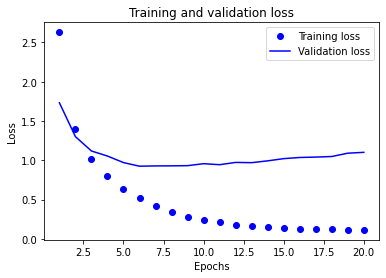

time: 304 ms (started: 2021-07-23 15:54:31 +08:00)


In [36]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

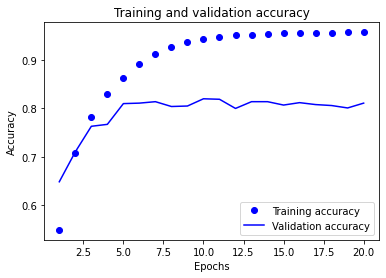

time: 259 ms (started: 2021-07-23 15:56:28 +08:00)


In [37]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

该模型在 9 个 epoch 后开始过度拟合。 让我们从头开始训练一个新模型九个时期，然后在测试集上对其进行评估。

In [38]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

time: 4.95 ms (started: 2021-07-23 15:59:13 +08:00)


In [40]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

time: 7.55 ms (started: 2021-07-23 15:59:34 +08:00)


In [41]:
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

Epoch 1/9
18/18 [==============================] - 1s 21ms/step - loss: 2.4781 - accuracy: 0.5412
Epoch 2/9
18/18 [==============================] - 0s 20ms/step - loss: 1.3457 - accuracy: 0.7116
Epoch 3/9
18/18 [==============================] - 0s 21ms/step - loss: 1.0071 - accuracy: 0.7901
Epoch 4/9
18/18 [==============================] - 0s 19ms/step - loss: 0.7916 - accuracy: 0.8324
Epoch 5/9
18/18 [==============================] - 0s 18ms/step - loss: 0.6206 - accuracy: 0.8706
Epoch 6/9
18/18 [==============================] - 0s 18ms/step - loss: 0.4950 - accuracy: 0.8971
Epoch 7/9
18/18 [==============================] - 0s 18ms/step - loss: 0.3934 - accuracy: 0.9186
Epoch 8/9
18/18 [==============================] - 0s 18ms/step - loss: 0.3183 - accuracy: 0.9300
Epoch 9/9
18/18 [==============================] - 0s 18ms/step - loss: 0.2678 - accuracy: 0.9390


time: 4.5 s (started: 2021-07-23 15:59:49 +08:00)


In [42]:
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 1s 12ms/step - loss: 0.9848 - accuracy: 0.7925
time: 1.15 s (started: 2021-07-23 16:00:11 +08:00)


以下是最终结果：

In [43]:
results

[0.9847751259803772, 0.7925200462341309]

time: 2.92 ms (started: 2021-07-23 16:00:46 +08:00)


这种方法的准确率达到了~80%。 对于平衡二元分类问题，纯随机分类器达到的准确率将是 50%。 但是在这种情况下，我们有 46 个类，它们的表示可能并不相同。 随机基线的准确度是多少？ 我们可以尝试快速实现一个来凭经验检查这一点：

In [44]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)

time: 1.35 ms (started: 2021-07-23 16:02:38 +08:00)


In [46]:
hits_array.mean()

0.18210151380231523

time: 2.58 ms (started: 2021-07-23 16:02:50 +08:00)


如您所见，随机分类器的分类准确率约为 19%，因此我们模型的结果在这方面看起来相当不错。

### 生成对新数据的预测

在新样本上调用模型的方法会返回对每个样本的所有 46 个主题进行预测的类概率分布。 让我们为所有测试数据生成主题预测。

In [47]:
predictions = model.predict(x_test)

time: 379 ms (started: 2021-07-23 16:04:09 +08:00)


“预测”中的每个条目都是一个长度为 46 的向量：

In [48]:
predictions[0].shape

(46,)

time: 2.52 ms (started: 2021-07-23 16:04:59 +08:00)


这个向量中的系数总和为 1，因为它们形成了一个概率分布：

In [49]:
np.sum(predictions[0])

0.9999998

time: 2.37 ms (started: 2021-07-23 16:06:01 +08:00)


最大的条目是预测类别——概率最高的类别：

In [50]:
np.argmax(predictions[0])

3

time: 2.51 ms (started: 2021-07-23 16:07:03 +08:00)


### 处理标签和损失的不同方式

我们之前提到过编码标签的另一种方法是将它们转换为整数张量，像这样：

In [51]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

time: 1.04 ms (started: 2021-07-23 16:08:42 +08:00)


这种方法唯一会改变的是损失函数的选择。 清单 4.21 中使用的损失函数 `categorical_crossentropy` 期望标签遵循分类编码。 对于整数标签，您应该使用 `sparse_categorical_crossentropy`：

In [53]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

time: 12.5 ms (started: 2021-07-23 16:10:27 +08:00)


这个新的损失函数在数学上仍然与 categorical_crossentropy 相同； 它只是有一个不同的界面。

### 具有足够大的中间层的重要性

我们之前提到过，由于最终输出是 46 维的，因此您应该避免使用少于 46 个单元的中间层。 现在让我们看看当您通过具有明显小于 46 维的中间层引入信息瓶颈时会发生什么：例如，4 维。

In [54]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 2.6865 - accuracy: 0.4049 - val_loss: 1.9452 - val_accuracy: 0.5840
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 1.6122 - accuracy: 0.6438 - val_loss: 1.4965 - val_accuracy: 0.6500
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 1.2531 - accuracy: 0.7010 - val_loss: 1.3528 - val_accuracy: 0.6960
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0805 - accuracy: 0.7409 - val_loss: 1.2985 - val_accuracy: 0.7060
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9716 - accuracy: 0.7578 - val_loss: 1.2775 - val_accuracy: 0.7060
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8934 - accuracy: 0.7704 - val_loss: 1.2945 - val_accuracy: 0.7010
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8290 - accuracy: 0.7806 - val_loss: 1.3007 - val_accuracy: 0.7050
Epoch 8/20
63

time: 21.5 s (started: 2021-07-23 16:13:13 +08:00)


该模型现在的峰值验证准确度约为 71%，绝对下降了 8%。 这种下降主要是因为您试图将大量信息（足以恢复 46 个类的分离超平面的信息）压缩到太低维的中间空间中。 该模型能够将必要的信息塞入这些四维大多数表示中，但不是全部。

### 进一步实验

* 尝试使用更大或更小的层：32 个单元、128 个单元等。
* 您在最终的 softmax 分类层之前使用了两个中间层。 现在尝试使用单个中间层或三个中间层。

### 总结

以下是你应该从这个例子中学到的东西：
* 如果你试图在类中对数据点进行分类，你的模型应该以大小为 N 的 Dense 层结束。
* 在单标签、多类分类问题中，您的模型应该以 softmax 激活结束，以便它输出 N 个输出类的概率分布。
* 分类交叉熵几乎总是您应该用于此类问题的损失函数。 它最小化了模型输出的概率分布与目标真实分布之间的距离。
* 在多类分类中有两种处理标签的方法：
    - 通过分类编码（也称为独热编码）对标签进行编码并使用 categorical_crossentropy 作为损失函数
    - 将标签编码为整数并使用 sparse_categorical_crossentropy 损失功能
* 如果您需要将数据分类为大量类别，则应避免由于中间层太小而在模型中造成信息瓶颈。

## 预测房价：回归示例

前两个示例被认为是分类问题，其目标是预测输入数据点的单个离散标签。 另一种常见的机器学习问题是 ，它包括预测一个连续值而不是一个离散标签：例如回归，根据气象数据预测明天的温度； 或根据其规格预测软件项目完成所需的时间。

> 不要混淆和算法回归逻辑回归。 令人困惑的是，逻辑回归不是回归算法——它是一种分类算法。

### 波士顿房价数据集

您将尝试预测 1970 年代中期给定波士顿郊区的房屋中位数价格，根据当时郊区的数据点，例如犯罪率、当地财产税率等。 您将使用的数据集与前两个示例有一个有趣的区别。 它的数据点相对较少：只有 506 个，分为 404 个训练样本和 102 个测试样本。 并且每个输入数据（例如，犯罪率）都有不同的尺度。 例如，一些值是比例，取值在 0 到 1 之间； 其他取值介于 1 和 12 之间，其他取值介于 0 和 100 之间，依此类推。

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

time: 12.4 ms (started: 2021-07-25 12:37:37 +08:00)


我们来看一下数据：

In [3]:
train_data.shape

(404, 13)

time: 10.1 ms (started: 2021-07-24 15:01:46 +08:00)


In [4]:
test_data.shape

(102, 13)

time: 2.83 ms (started: 2021-07-24 15:01:48 +08:00)


如您所见，您有 404 个训练样本和 102 个测试样本，每个样本具有 13 个数值特征，例如人均犯罪率、每户住宅的平均房间数、
高速公路等等。

目标是自住房屋的中值，以千美元为单位：

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

time: 5.37 ms (started: 2021-07-24 15:01:50 +08:00)


价格通常在 10,000 美元到 50,000 美元之间。 如果这听起来很便宜，请记住这是 1970 年代中期，这些价格没有根据通货膨胀进行调整。

### 准备数据

将所有范围都大不相同的神经网络值输入到神经网络中将是有问题的。 模型或许能够自动适应这种异构数据，但这肯定会让学习变得更加困难。 处理此类数据的一种普遍最佳做法是进行特征归一化：对于输入数据中的每个特征（输入数据矩阵中的一列），您减去特征的均值并除以标准差，以便 该特征以 0 为中心并具有单位标准偏差。 这在 NumPy 中很容易完成。

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

time: 1.68 ms (started: 2021-07-24 15:01:53 +08:00)


In [7]:
test_data -= mean
test_data /= std

time: 427 µs (started: 2021-07-24 15:01:54 +08:00)


请注意，用于归一化测试数据的数量是使用训练数据计算的。 您永远不应该在工作流程中使用根据测试数据计算的任何数量，即使对于
像数据规范化这样简单的事情。

### 构建模型

由于可用样本太少，您将使用一个非常小的模型，其中包含两个中间层，每个层有 64 个单元。 一般来说，你拥有的训练数据越少，过拟合就越严重，使用小模型是减轻过拟合的一种方法。

In [8]:
# 因为您需要多次实例化同一个模型，所以您使用一个函数来构造它。

def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
 ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

time: 740 µs (started: 2021-07-24 15:01:57 +08:00)


模型以单个单元结束，没有激活（它将是一个线性层）。 这是标量回归（尝试预测单个连续值的回归）的典型设置。 应用激活函数会限制输出的范围； 例如，如果您将激活函数应用于最后一层，则模型只能学习 sigmoid 来预测 0 到 1 之间的值。这里，因为最后一层是纯线性的，模型可以自由地学习预测任何范围内的值 .

请注意，您使用损失函数编译模型 - mse 均方误差，预测与目标之间差异的平方。 这是一种广泛用于回归问题的损失函数。

您还在训练期间监控一个新指标：平均绝对误差 (MAE)。 它是预测和目标之间差异的绝对值。 例如，此问题的 MAE 为 0.5 意味着您的预测平均偏离 500 美元。

### 使用 K 折验证来验证您的方法

要在不断调整模型参数（例如用于训练的 epoch 数）的同时评估模型，您可以将数据拆分为训练集和验证集，就像在前面的示例中所做的那样。 但是因为数据点太少，验证集最终会非常小（例如，大约 100 个示例）。 因此，验证分数可能会发生很大变化，具体取决于您选择用于验证的数据点以及您选择用于训练的数据点：验证分数可能相对于方差验证拆分而言较高。 这将阻止您可靠地评估您的模型。

这种情况下的最佳实践是使用交叉验证（见图 4.8）。 它包括将可用数据分成 K 个分区（通常 K = 4 或 5）的 K 折，实例化相同的 K
模型，并在 K-1 个分区上训练每个模型，同时评估剩余的分区。 所用模型的验证分数是获得的 K 个验证分数的平均值。 就代码而言，这很简单。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gss1f3ryicj31cy0myq57.jpg)

In [22]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

time: 781 µs (started: 2021-07-24 15:17:35 +08:00)


In [23]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

for i in range(k):
    print(f"Processing fold #{i}")
    
    # 准备验证数据：来自分区 #k 的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
   
    # 准备训练数据：来自所有其他分区的数据
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # 构建 Keras 模型（已编译）
    model = build_model()
    
    # 训练模型（在静默模式下，verbose = 0）
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    
    # 根据验证数据评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
    
    #
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
time: 1min 4s (started: 2021-07-24 15:17:37 +08:00)


使用 num_epochs = 100 运行它会产生以下结果：

In [24]:
all_scores

[2.1525533199310303,
 2.4750516414642334,
 2.5435984134674072,
 2.3341240882873535]

time: 2.23 ms (started: 2021-07-24 15:21:11 +08:00)


In [25]:
np.mean(all_scores)

2.376331865787506

time: 2.04 ms (started: 2021-07-24 15:21:13 +08:00)


不同的运行确实显示了相当不同的验证分数，从 2.1 到 3.1。 平均值 (2.6) 是比任何单个分数都更可靠的指标——这是 K 折交叉验证的全部要点。 在这种情况下，您平均减少 2,600 美元，考虑到价格从 10,000 美元到 50,000 美元不等，这一点很重要。

让我们尝试将模型训练更长时间：500 个 epoch。 为了记录模型在每个时期的表现，您将修改训练循环以保存每个时期的验证分数日志。

In [26]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    # 准备验证数据：来自分区 #k 的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
   
    # 准备训练数据：来自所有其他分区的数据
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # 构建 Keras 模型（已编译）
    model = build_model()
    
    # 训练模型（在静默模式下，verbose = 0）
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    mae_history = history.history["val_mae"]
    
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
time: 7min 22s (started: 2021-07-24 15:29:05 +08:00)


然后，您可以计算所有折叠的每个周期 MAE 分数的平均值。

In [27]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

time: 7.96 ms (started: 2021-07-24 15:36:27 +08:00)


让我们绘制这个图； 见图 4.9。

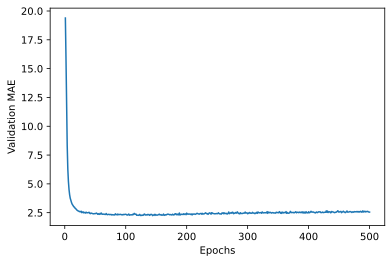

time: 181 ms (started: 2021-07-24 15:39:39 +08:00)


In [33]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

由于缩放问题，阅读该图可能有点困难：前几个周期的验证 MAE 显着高于随后的值。 让我们省略前 10 个数据点，它们的比例与曲线的其余部分不同：

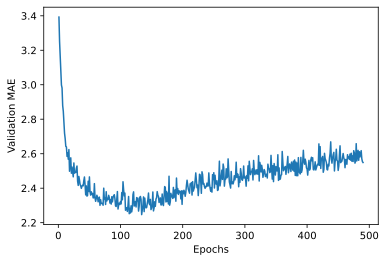

time: 423 ms (started: 2021-07-24 15:39:29 +08:00)


In [32]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

根据此图，验证 MAE 在 120-140 个 epoch 后停止显着提高（这个数字包括我们省略的 10 个 epoch）。 过了那个点，你开始过度拟合。

完成模型的其他参数调整后（除了 epoch 数，您还可以调整中间层的大小），您可以在所有训练数据上使用最佳参数训练最终生产模型 ，然后看它在测试数据上的表现。

In [30]:
model = build_model()

model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 8ms/step - loss: 17.1650 - mae: 2.8036
time: 27.7 s (started: 2021-07-24 15:38:04 +08:00)


这是最终结果：

In [34]:
test_mae_score

2.803586721420288

time: 2.51 ms (started: 2021-07-24 15:42:34 +08:00)


你仍然低了大约 2500 美元。

### 生成对新数据的预测

在我们的二元分类模型上调用 predict() 时，我们为每个输入样本检索了 0 到 1 之间的标量分数。 使用我们的多类分类模型，我们为每个样本检索了所有类的概率分布。 现在，使用这个标量回归模型， predict() 返回模型对样本价格的数千美元的猜测：

In [36]:
predictions = model.predict(test_data)

time: 143 ms (started: 2021-07-24 15:45:26 +08:00)


In [37]:
predictions[0]

array([8.6478815], dtype=float32)

time: 2.42 ms (started: 2021-07-24 15:45:33 +08:00)


测试集中的第一栋房子的价格预计约为 10,000 美元。

### 尝试使用autokeras

In [9]:
import autokeras as ak

time: 3.66 s (started: 2021-07-25 12:40:00 +08:00)


In [4]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

time: 5.99 ms (started: 2021-07-25 12:37:50 +08:00)


In [6]:
train_data.shape

(404, 13)

time: 3.76 ms (started: 2021-07-25 12:39:07 +08:00)


In [12]:
train_targets.shape

(404,)

time: 2.41 ms (started: 2021-07-25 12:41:54 +08:00)


In [29]:
dir(tf.keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'huber',
 'kl_divergence',
 'kld',
 'kullback_leibler_divergence',
 'log_cosh',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

time: 4.52 ms (started: 2021-07-25 13:20:12 +08:00)


In [33]:
# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True, max_trials=5, loss="mse", metrics="mae"
)  # It tries 3 different models.

time: 11 ms (started: 2021-07-25 13:22:14 +08:00)


In [34]:
reg.fit(x=train_data, y = train_targets)

Trial 5 Complete [00h 00m 53s]
val_loss: 7.9547929763793945

Best val_loss So Far: 5.462915897369385
Total elapsed time: 00h 06m 25s
INFO:tensorflow:Oracle triggered exit
Epoch 1/250
13/13 [==============================] - 1s 17ms/step - loss: 574.1790 - mae: 22.0731
Epoch 2/250
13/13 [==============================] - 0s 16ms/step - loss: 540.6957 - mae: 21.3892 0s - loss: 512.0692 - mae: 20.
Epoch 3/250
13/13 [==============================] - 0s 16ms/step - loss: 504.0912 - mae: 20.6075
Epoch 4/250
13/13 [==============================] - 0s 16ms/step - loss: 460.4326 - mae: 19.6278
Epoch 5/250
13/13 [==============================] - 0s 16ms/step - loss: 407.4809 - mae: 18.3676
Epoch 6/250
13/13 [==============================] - 0s 15ms/step - loss: 344.5948 - mae: 16.7594
Epoch 7/250
13/13 [==============================] - 0s 15ms/step - loss: 273.5533 - mae: 14.7213
Epoch 8/250
13/13 [==============================] - 0s 15ms/step - loss: 201.5718 - mae: 12.2677
Epoch 9/250
13

In [35]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 13)                0         
_________________________________________________________________
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense (Dense)                (None, 32)                448       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [24]:
from tensorflow.keras.utils import plot_model

time: 480 µs (started: 2021-07-25 13:16:47 +08:00)


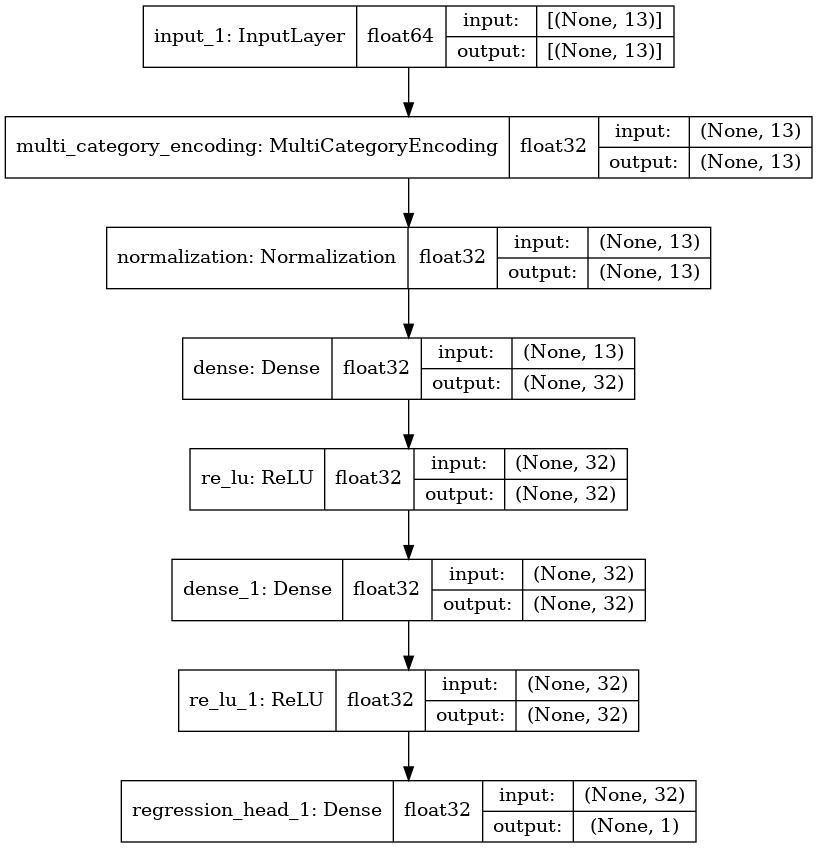

time: 456 ms (started: 2021-07-25 13:52:50 +08:00)


In [36]:
plot_model(model, show_dtype=True, show_shapes=True)

### 总结

以下是您应该从这个标量回归示例中获得的信息：
* 回归使用与我们用于分类的损失函数不同的损失函数完成。均方误差 (MSE) 是通常用于回归的损失函数。
* 同样，用于回归的评估指标与用于分类的评估指标不同； 自然，准确率的概念不适用于回归。 一个常见的回归指标是平均绝对误差 (MAE)。
* 当输入数据中的特征具有不同范围的值时，每个特征都应作为预处理步骤独立缩放。
* 当可用数据很少时，使用 K 折验证是可靠评估模型的好方法。
* 当可用的训练数据很少时，最好使用中间层很少（通常只有一两个）的小模型，以避免严重的过拟合。

## 本章总结

* 矢量数据上三种最常见的机器学习任务是二元分类、多类分类和标量回归。
    - 本章前面的“总结”部分总结了您在每项任务中学到的要点。
    - 回归使用与分类不同的损失函数和不同的评估指标。
* 在将原始数据输入神经网络之前，您通常需要对其进行预处理。
* 当您的数据具有不同范围的特征时，作为预处理的一部分，独立缩放每个特征。
* 随着训练的进行，神经网络最终开始过度拟合并在从未见过的数据上获得更糟糕的结果。
* 如果你的训练数据不多，请使用只有一两个中间层的小模型，以避免严重的过拟合。
* 如果你的数据被分成很多类别，中间层太小可能会造成信息瓶颈。
* 当您处理少量数据时，K 折验证可以帮助可靠地评估您的模型。